
# Lab 7 — t-SNE & PCA





In [ ]:

# === Imports & Settings ===
import os, re, glob, time, unicodedata, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from IPython.display import display

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.dpi'] = 120

print('Versions -> numpy', np.__version__, '| pandas', pd.__version__)


Versions -> numpy 2.0.2 | pandas 2.2.2


## 1) Загрузка данных

In [ ]:

# Colab-friendly upload block
fname = None
try:
    from google.colab import files  # type: ignore
    print("Upload 'Global finance data.csv' ")
    uploaded = files.upload()
    if uploaded:
        fname = list(uploaded.keys())[0]
except Exception:
    print("files.upload() недоступен — ищем файл локально.")

if fname is None:
    patterns = [r".*global.*finance.*\.csv$", r".*finance.*global.*\.csv$"]
    candidates = []
    for path in glob.glob("*.csv") + glob.glob("/content/*.csv") + glob.glob("/mnt/data/*.csv"):
        name = os.path.basename(path).lower()
        for p in patterns:
            if re.match(p, name):
                candidates.append(path); break
    fname = candidates[0] if candidates else "Global finance data.csv"

def robust_read_csv(path):
    for enc in ("utf-8", "cp1251", "latin1"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    return pd.read_csv(path)

df = robust_read_csv(fname)
print("Loaded:", fname, "| shape:", df.shape)
display(df.head(5))
display(df.info())
display(df.describe(include='all').transpose().head(25))


Upload 'Global finance data.csv' (или аналогичный)


Saving Global finance data.csv to Global finance data.csv
Loaded: Global finance data.csv | shape: (39, 26)


,Country,Date,Stock_Index,Index_Value,Daily_Change_Percent,Market_Cap_Trillion_USD,GDP_Growth_Rate_Percent,Inflation_Rate_Percent,Interest_Rate_Percent,Unemployment_Rate_Percent,...,Commodity_Index,Oil_Price_USD_Barrel,Gold_Price_USD_Ounce,Bond_Yield_10Y_Percent,Credit_Rating,Political_Risk_Score,Banking_Sector_Health,Real_Estate_Index,Export_Growth_Percent,Import_Growth_Percent
0,United States,2024-08-15,S&P_500,5437.2,0.34,51.2,2.8,2.9,5.50,3.7,...,1.12,77.85,2487.5,4.25,AAA,8.1,Strong,145.6,3.2,2.8
1,China,2024-08-15,Shanghai_Composite,2891.6,-0.82,12.4,5.2,0.8,3.10,5.2,...,0.98,77.85,2487.5,2.15,A+,6.7,Moderate,98.7,8.9,6.1
2,Japan,2024-08-15,Nikkei_225,36789.1,1.24,6.8,0.9,2.8,-0.10,2.4,...,1.05,77.85,2487.5,0.89,A+,8.4,Strong,89.3,5.1,4.7
3,Germany,2024-08-15,DAX,18234.5,0.67,2.9,0.3,2.2,4.50,3.1,...,1.08,77.85,2487.5,2.31,AAA,8.7,Strong,112.4,2.1,1.8
4,United Kingdom,2024-08-15,FTSE_100,8156.3,-0.15,3.1,1.1,2.0,5.25,4.2,...,1.06,77.85,2487.5,3.89,AA,7.9,Moderate,97.8,0.9,1.2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              39 non-null     object 
 1   Date                                 39 non-null     object 
 2   Stock_Index                          39 non-null     object 
 3   Index_Value                          39 non-null     float64
 4   Daily_Change_Percent                 39 non-null     float64
 5   Market_Cap_Trillion_USD              39 non-null     float64
 6   GDP_Growth_Rate_Percent              39 non-null     float64
 7   Inflation_Rate_Percent               39 non-null     float64
 8   Interest_Rate_Percent                39 non-null     float64
 9   Unemployment_Rate_Percent            39 non-null     float64
 10  Currency_Code                        39 non-null     object 
 11  Exchange_Rate_USD                 

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Country,39,39,United States,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,39,1,2024-08-15,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stock_Index,39,39,S&P_500,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Index_Value,39.0,NaN,NaN,NaN,59964.774359,249537.018541,889.3,2711.8,8156.3,23012.25,1567890.2
Daily_Change_Percent,39.0,NaN,NaN,NaN,0.654103,0.834672,-1.23,0.31,0.67,0.89,3.45
Market_Cap_Trillion_USD,39.0,NaN,NaN,NaN,2.912821,8.260615,0.03,0.4,0.7,2.45,51.2
GDP_Growth_Rate_Percent,39.0,NaN,NaN,NaN,2.415385,1.874558,-1.9,1.15,2.4,3.15,6.8
Inflation_Rate_Percent,39.0,NaN,NaN,NaN,11.023077,34.828629,-0.4,1.95,2.8,4.3,211.4
Interest_Rate_Percent,39.0,NaN,NaN,NaN,10.64359,21.866714,-0.1,4.05,4.75,6.5,133.0
Unemployment_Rate_Percent,39.0,NaN,NaN,NaN,5.887179,4.636138,1.2,3.3,5.1,7.3,28.7


## 2) Метки для окраски точек

In [ ]:

def normalize(s):
    if s is None: return ""
    s = str(s)
    s = unicodedata.normalize('NFKD', s)
    s = s.encode('ascii', 'ignore').decode('ascii')
    s = s.lower()
    s = re.sub(r"[^a-z0-9]+", "", s)
    return s

# Try to use an existing categorical column
label_col = None
for c in df.columns:
    if df[c].dtype == 'object' or df[c].dtype.name == 'category':
        nunq = df[c].nunique(dropna=True)
        if 2 <= nunq <= 12:
            label_col = c; break

constructed = False
if label_col is None:
    preferred_numeric = ["inflation","unemployment","debtgdp","governmentdebt","interest","gdpgrowth","gdp"]
    numeric_df = df.select_dtypes(include=[np.number])
    chosen_num = None
    for c in numeric_df.columns:
        if any(kw in normalize(c) for kw in preferred_numeric):
            chosen_num = c; break
    if chosen_num is None and len(numeric_df.columns) > 0:
        chosen_num = numeric_df.var().sort_values(ascending=False).index[0]
    q = pd.qcut(numeric_df[chosen_num].rank(method='first'), 3, labels=["Low","Medium","High"])
    df["_constructed_target"] = q.astype(str)
    label_col = "_constructed_target"
    constructed = True

print("Color-by column:", label_col, "| constructed:", constructed)
display(df[label_col].value_counts())


Color-by column: Banking_Sector_Health | constructed: False


,count
Banking_Sector_Health,
Moderate,18
Strong,14
Weak,7


## 3) Предобработка признаков

In [ ]:

Xdf = df.select_dtypes(include=[np.number]).copy()

# Drop all-NaN columns; fill missing with median
na_all = [c for c in Xdf.columns if Xdf[c].isna().all()]
Xdf = Xdf.drop(columns=na_all)
for c in Xdf.columns:
    if Xdf[c].isna().any():
        Xdf[c] = Xdf[c].fillna(Xdf[c].median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xdf.values)

n_samples, n_features = X_scaled.shape
pca_dim = int(min(30, max(2, n_features)))
pca_full = PCA(n_components=pca_dim, random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)

# prepare labels/colors
labels = df[label_col].astype(str).values
classes = sorted(pd.Series(labels).unique())
class_to_int = {c:i for i,c in enumerate(classes)}
c_vals = np.array([class_to_int[v] for v in labels])

print("n_samples:", n_samples, "| n_features:", n_features, "| PCA_dim:", pca_dim)


n_samples: 39 | n_features: 20 | PCA_dim: 20


## 4) PCA (2D)

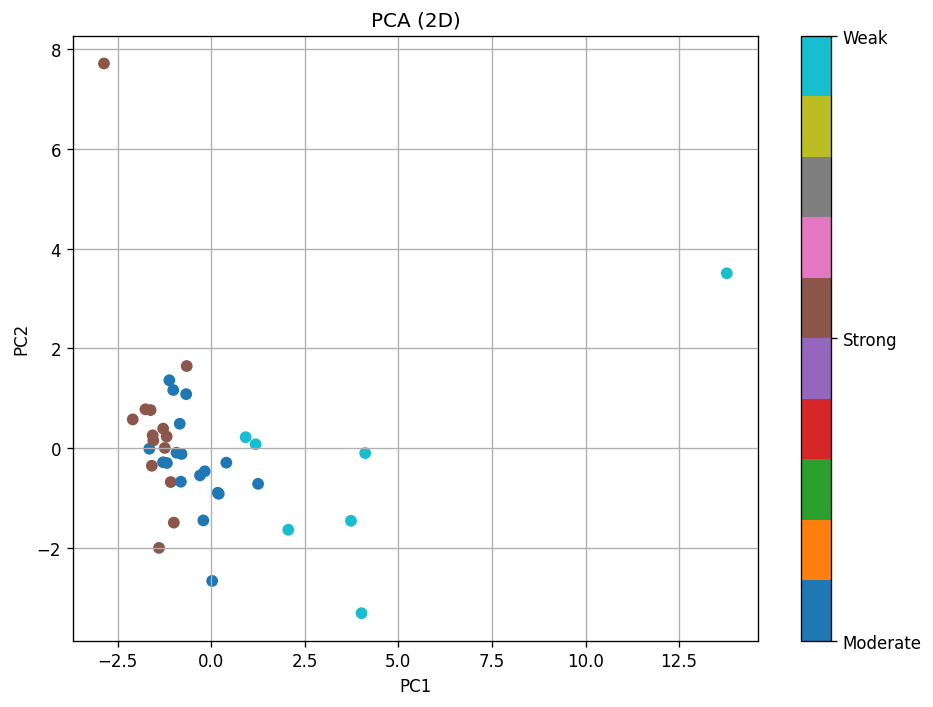

In [ ]:

pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
s = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=c_vals, cmap='tab10', s=50, edgecolors='none')
plt.title("PCA (2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
cb = plt.colorbar(s, ticks=np.arange(len(classes)))
cb.ax.set_yticklabels(classes)
plt.tight_layout(); plt.show()


## 5) t-SNE (2D) — **динамический perplexity**

Perplexities to run: [5, 30]


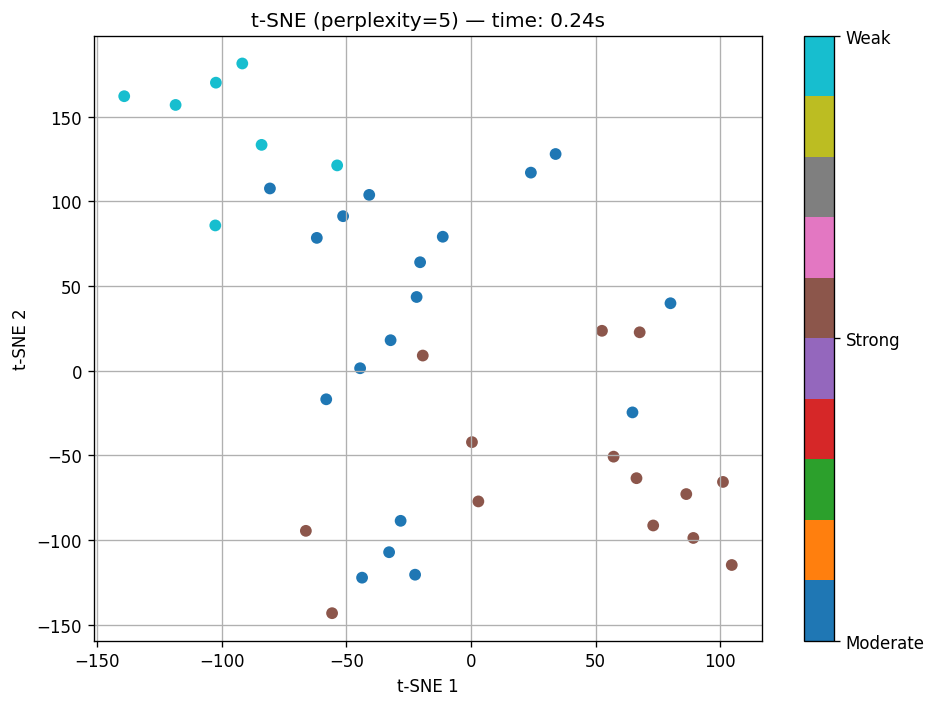

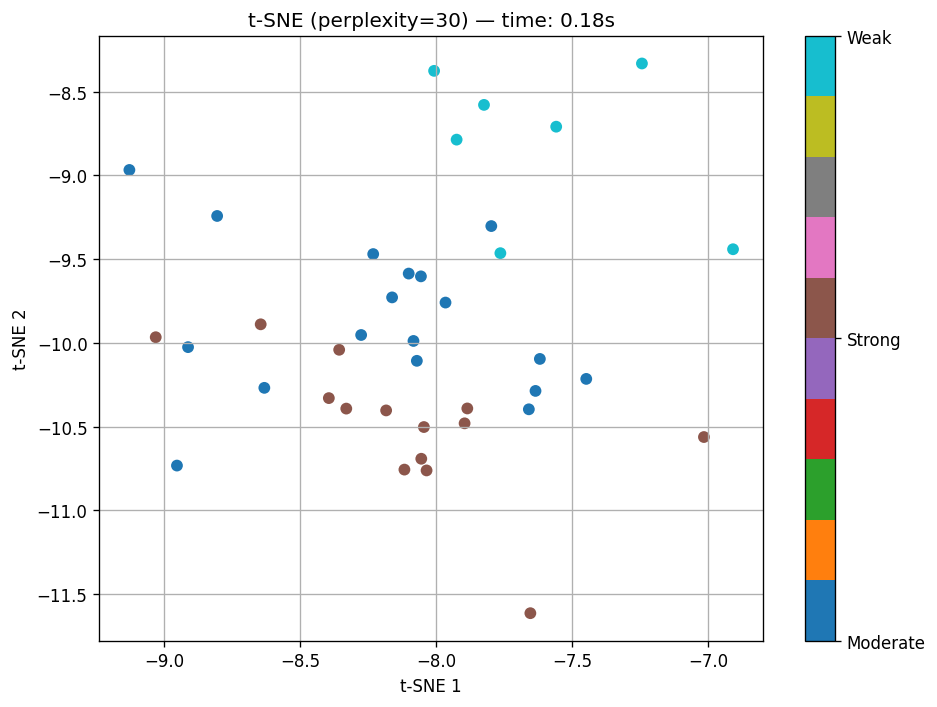

In [ ]:

def run_tsne(X, perplexity=30, n_iter=1000, random_state=42):
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=random_state, init='pca')
    t0 = time.time()
    emb = tsne.fit_transform(X)
    t1 = time.time()
    return emb, (t1 - t0)

# Base candidates
base_perps = [5, 30, 50]
# Enforce < n_samples and at least 2
perps = [p for p in base_perps if p < n_samples]
if not perps:
    # choose a safe default based on size: about n_samples//3 but >=2
    perps = [max(2, min(30, n_samples//3 if n_samples>=3 else 2))]

print("Perplexities to run:", perps)

tsne_results = {}
for p in perps:
    try:
        emb, dt = run_tsne(X_pca_full, perplexity=p, n_iter=1000, random_state=42)
    except ValueError as e:
        # safety fallback: reduce perplexity further if needed
        safe_p = max(2, min(p-1, n_samples-1))
        emb, dt = run_tsne(X_pca_full, perplexity=safe_p, n_iter=1000, random_state=42)
        p = safe_p
    tsne_results[p] = (emb, dt)
    plt.figure(figsize=(8,6))
    s = plt.scatter(emb[:,0], emb[:,1], c=c_vals, cmap='tab10', s=50, edgecolors='none')
    plt.title(f"t-SNE (perplexity={p}) — time: {dt:.2f}s")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    cb = plt.colorbar(s, ticks=np.arange(len(classes)))
    cb.ax.set_yticklabels(classes)
    plt.tight_layout(); plt.show()
